In [2]:
import numpy as np
import matplotlib.pyplot as plt

import math
import scipy.sparse as sps

from scipy.sparse.linalg import cg as sp_cg

import jlinops
import sampi

import cupy as cp

/opt/conda/envs/jlinops/lib/python3.11/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [3]:
ground_truth = jlinops.graecolatinsquare(which=3)
#ground_truth = jlinops.cameraman()
img_shape = ground_truth.shape
print(img_shape)
noise_sigma = 0.1
n = math.prod(ground_truth.shape)
#F = jlinops.IdentityOperator((n,n))
F = jlinops.Gaussian2DBlurOperator(img_shape, blur_sigma=4.0, mode="constant")
noise_var = noise_sigma**2
print(noise_var)
np.random.seed(0)
noisy_signal = F.matvec(ground_truth.flatten()) + noise_sigma*np.random.normal(size=n)

(648, 648)
0.010000000000000002


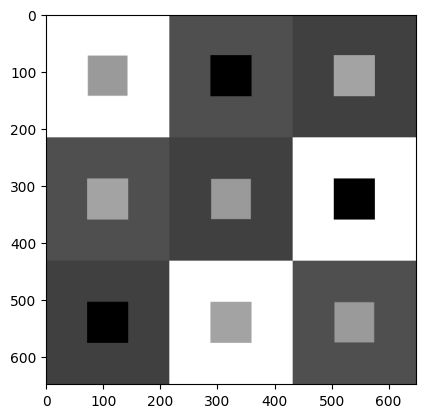

In [4]:
plt.imshow(ground_truth, cmap="gray")
plt.show()

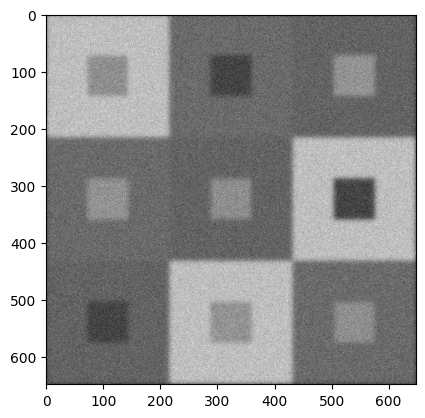

In [5]:
plt.imshow(noisy_signal.reshape(img_shape), cmap="gray")
plt.show()

In [6]:
W = np.ones(n)/np.linalg.norm(np.ones(n))
W = jlinops.MatrixLinearOperator(W)

R = jlinops.Neumann2D(img_shape)
def Rpinv_factory(theta, *args, **kwargs):
    return jlinops.CGWeightedNeumann2DPinvOperator(img_shape, weights=1.0/np.sqrt(theta), tol=1e-5, *args, **kwargs)
#tol = 1e-2
pdata = {
    "W": W,
    "Rpinv_factory": Rpinv_factory,
}

# Fixed noise variance to true

In [7]:
# Prior parameters
reg_lambda = 2*1e1
vartheta = 2/(reg_lambda**2)
hyperparams_learned = {
    "prior": {
        "r": 1.0,
        "beta": 1.5 + 1e-3,
        "vartheta": vartheta,
    },
    "noise_var": {
        "r": -1.0,
        "beta": 1,
        "vartheta": 1e-4,
    }
}

hyperparams_fixed = {
    "prior": {
        "r": 1.0,
        "beta": 1.5 + 1e-3,
        "vartheta": vartheta,
    },
}


# Create solver
solver_fixed = sampi.IASSolver(F, R, noisy_signal, hyperparams_fixed, noise_var=noise_var, pdata=pdata)
solver_learned = sampi.IASSolver(F, R, noisy_signal, hyperparams_learned, noise_var=None, pdata=pdata)

In [24]:
vartheta

0.005

In [8]:
# Initialize everything at the least-squares reconstruction?
x0, _ = sp_cg( (F.T @ F) + 1e0*(R.T @ R), F.T @ noisy_signal, tol=1e-4  )

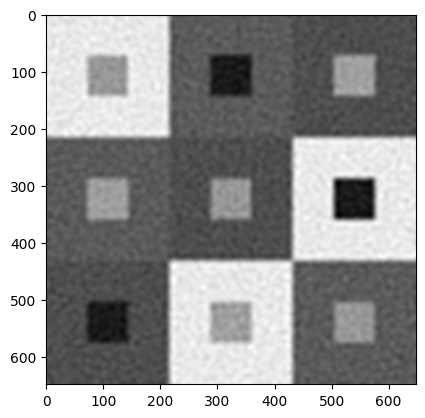

In [9]:
plt.imshow( x0.reshape(img_shape) , cmap="gray")
plt.show()

In [10]:
TOL = 1e-3
EPS = 1e-3
MAX_ITERS = 500

In [11]:
data_normal_fixed = solver_fixed.solve(max_iters=MAX_ITERS, x0=x0.flatten(), priorconditioning=False, 
                    early_stopping=True, warmstarting=True, 
                    eps=EPS, x_update_solver_params={"tol":TOL},
                   x_update_device="gpu")

In [12]:
data_normal_learned = solver_learned.solve(max_iters=MAX_ITERS, x0=x0.flatten(), priorconditioning=False, 
                    early_stopping=True, warmstarting=True, 
                    eps=EPS, x_update_solver_params={"tol":TOL},
                   x_update_device="gpu")

In [13]:
data_priorconditioned_fixed = solver_fixed.solve(max_iters=MAX_ITERS, x0=x0.flatten(), priorconditioning=True, 
                    early_stopping=True, warmstarting=True, 
                    eps=EPS, x_update_solver_params={"tol":TOL},
                   x_update_device="gpu")

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

In [14]:
data_priorconditioned_learned = solver_learned.solve(max_iters=MAX_ITERS, x0=x0.flatten(), priorconditioning=True, 
                    early_stopping=True, warmstarting=True, 
                    eps=EPS, x_update_solver_params={"tol":TOL},
                   x_update_device="gpu")

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

In [15]:
data_normal_learned_bad_init = solver_learned.solve(max_iters=MAX_ITERS, x0=None, priorconditioning=False, 
                    early_stopping=True, warmstarting=True, 
                    eps=EPS, x_update_solver_params={"tol":TOL},
                   x_update_device="gpu")

# Plot

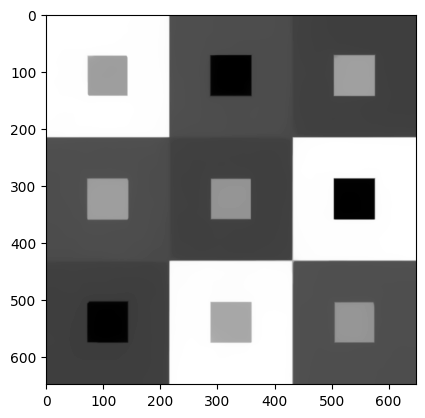

In [17]:
plt.imshow( data_normal_fixed["x"].reshape(img_shape) , cmap="gray")
plt.show()

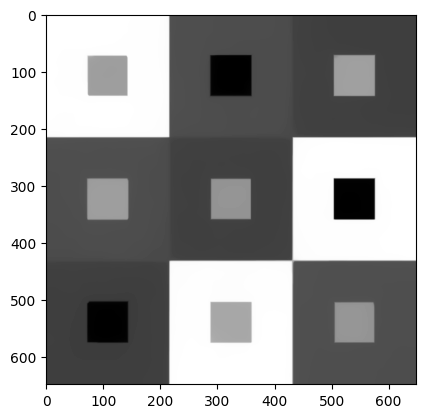

In [18]:
plt.imshow( data_normal_learned["x"].reshape(img_shape) , cmap="gray")
plt.show()

# Save for plotting

In [20]:
import pickle

In [21]:
data_dct = {
    "data_normal_learned": data_normal_learned,
    "data_normal_fixed": data_normal_fixed,
    "data_priorconditioned_learned": data_priorconditioned_learned,
    "data_priorconditioned_fixed": data_priorconditioned_fixed,
    "data_normal_learned_bad_init": data_normal_learned_bad_init,
}

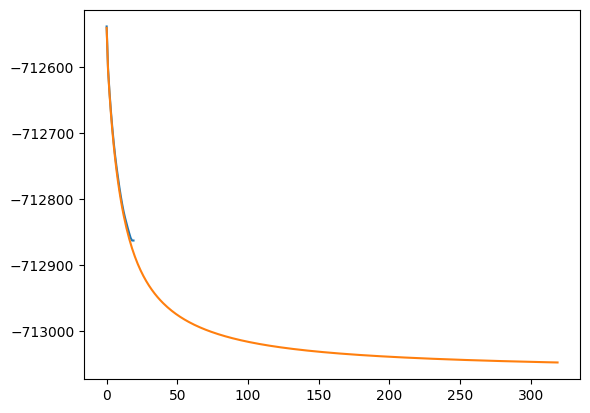

In [23]:
plt.plot(data_dct["data_priorconditioned_learned"]["obj_vals"][10:])
plt.plot(data_dct["data_normal_learned"]["obj_vals"][10:])
plt.show()

In [125]:
# Pickle the dictionary to a file
with open('2d_example_data.pickle', 'wb') as handle:
    pickle.dump(data_dct, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load and plot

In [127]:
# Unpickle the dictionary from the file
with open('2d_example_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

print(data.keys())

dict_keys(['data_normal_learned', 'data_normal_fixed', 'data_priorconditioned_learned', 'data_priorconditioned_fixed', 'data_normal_learned_bad_init'])


In [129]:
data["data_normal_fixed"]["x"]

array([0.84421052, 0.84420646, 0.84419847, ..., 0.34094148, 0.34094205,
       0.3409423 ])

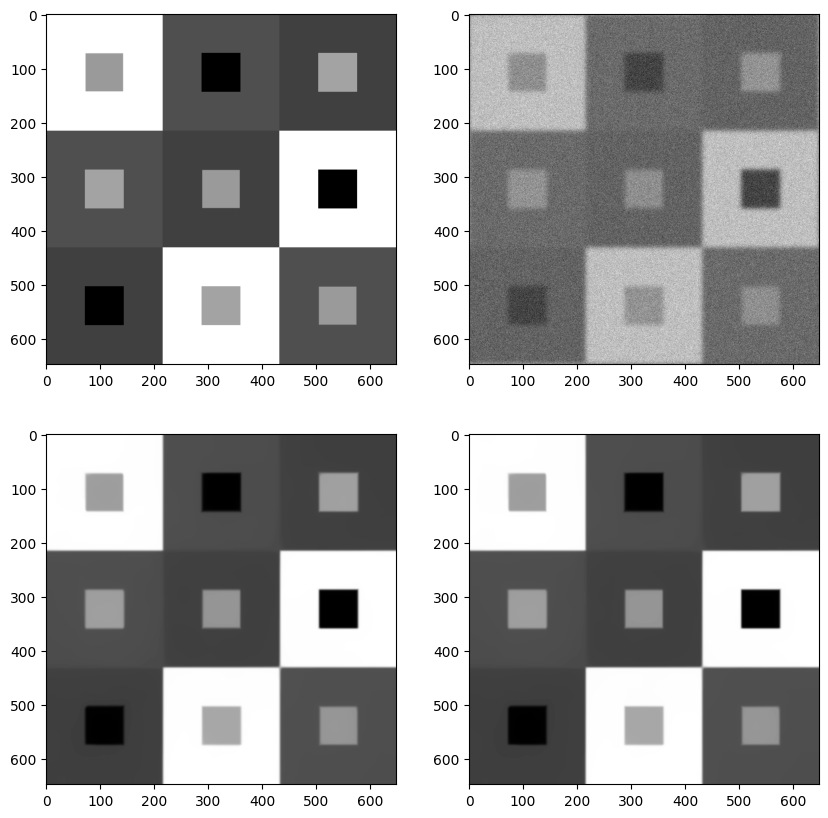

In [132]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))

axs[0,0].imshow( ground_truth, cmap="gray" )

axs[0,1].imshow( noisy_signal.reshape(img_shape), cmap="gray" )

axs[1,0].imshow( data["data_priorconditioned_fixed"]["x"].reshape(img_shape), cmap="gray" )

axs[1,1].imshow( data["data_priorconditioned_learned"]["x"].reshape(img_shape), cmap="gray" )


plt.show()

# Old

In [27]:
data.keys()

dict_keys(['x', 'theta', 'n_cg_its_per_iteration', 'converged', 'obj_vals', 'noise_var', 'noise_vars', 'n_iters', 'n_Rpinv_matvec_cg_its_per_iteration', 'n_Rpinv_rmatvec_cg_its_per_iteration', 'obj_vals_each_update'])

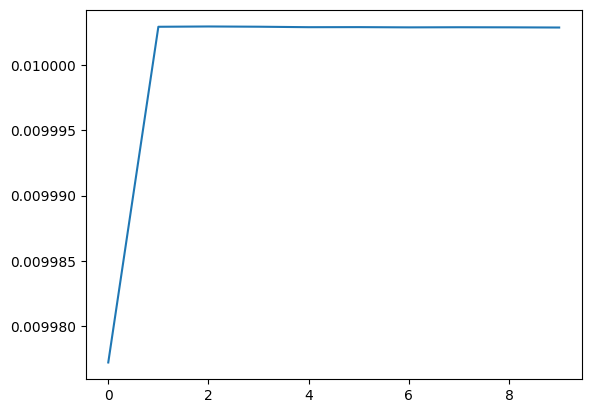

In [70]:
plt.plot(data["noise_vars"])
plt.show()

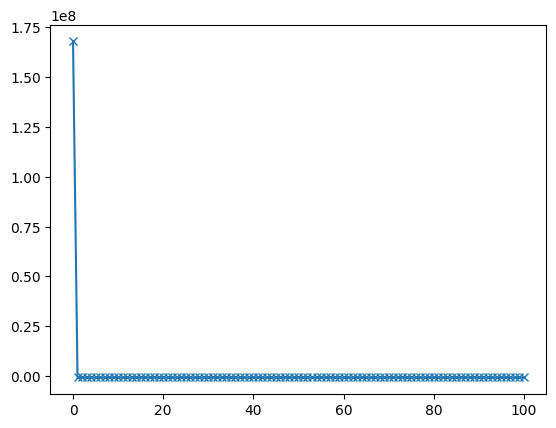

In [71]:
plt.plot(data["obj_vals"], marker="x")
plt.show()

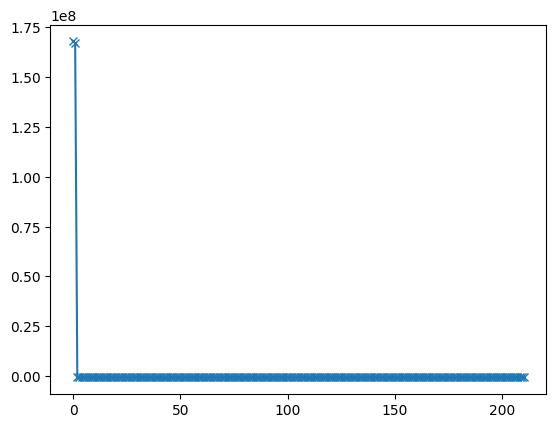

In [72]:
plt.plot(data["obj_vals_each_update"][:], marker="x")
plt.show()

In [73]:
noise_var

0.010000000000000002

In [74]:
data["noise_var"]

0.01000284795409304

In [75]:
np.amin(data["noise_vars"])

0.009977240731895463

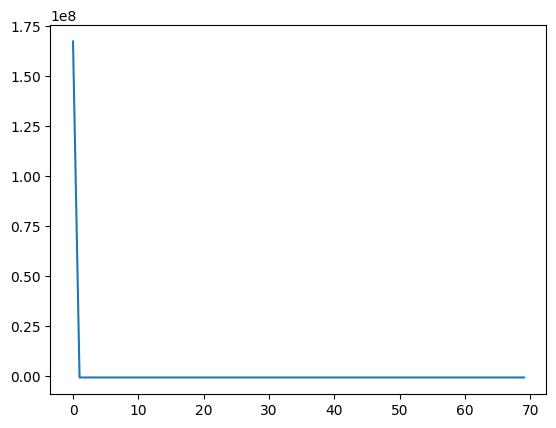

In [76]:
plt.plot(data["obj_vals_each_update"][1::3])
plt.show()

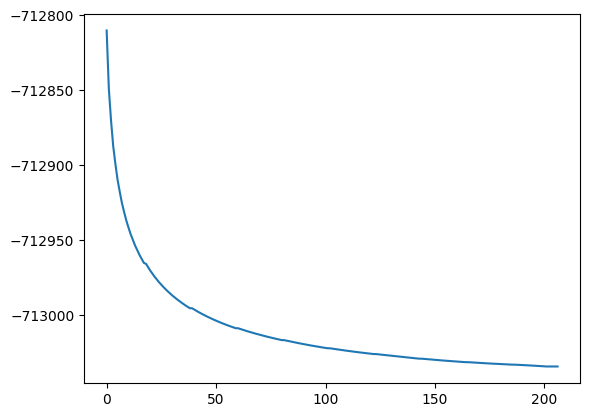

In [77]:
plt.plot(data["obj_vals_each_update"][4:])
plt.show()

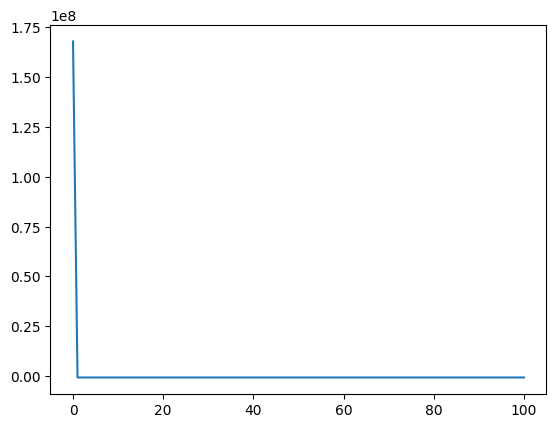

In [78]:
plt.plot(data["obj_vals"])
plt.show()

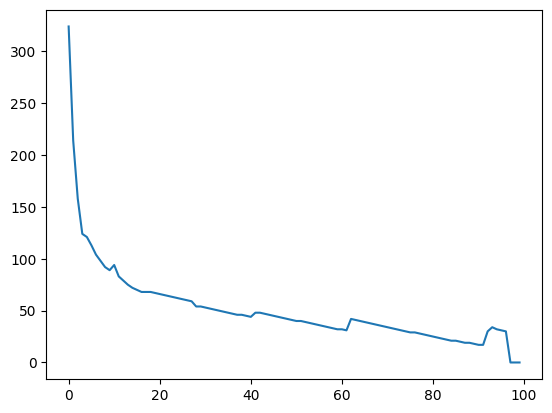

In [79]:
plt.plot(data["n_cg_its_per_iteration"])
plt.show()

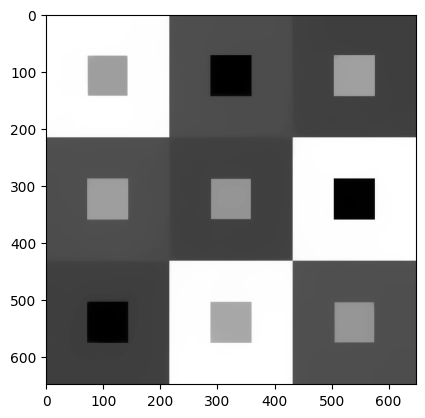

In [80]:
plt.imshow( data["x"].reshape(img_shape) , cmap="gray")
plt.show()

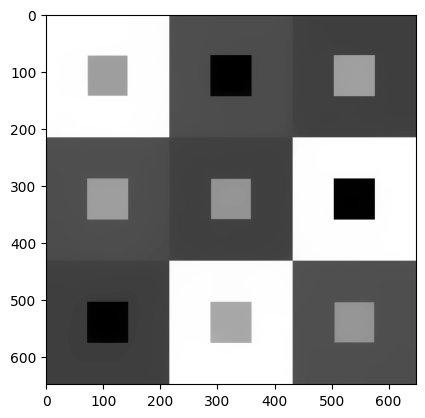

In [81]:
plt.imshow( datap["x"].reshape(img_shape) , cmap="gray")
plt.show()

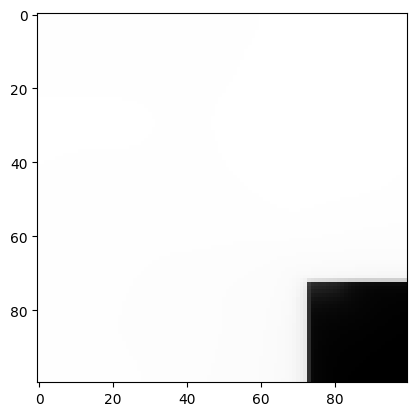

In [68]:
plt.imshow( data["x"].reshape(img_shape)[:100,:100] , cmap="gray")
plt.show()

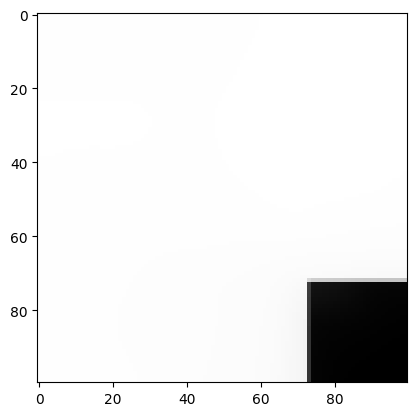

In [43]:
plt.imshow( datap["x"].reshape(img_shape)[:100,:100] , cmap="gray")
plt.show()

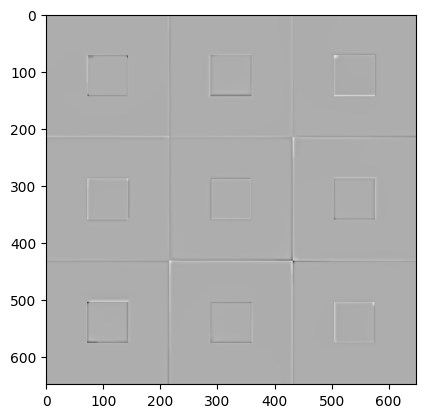

In [64]:
plt.imshow( datap["x"].reshape(img_shape) - data["x"].reshape(img_shape), cmap="gray")
plt.show()

In [51]:
(R @ datap["x"]).shape

(839808,)

In [56]:
mid = int(R.shape[0]/2)

In [61]:
r1 = (R @ data["x"])[:mid].reshape(img_shape)
r2 = (R @ data["x"])[mid:].reshape(img_shape)
r1p = (R @ datap["x"])[:mid].reshape(img_shape)
r2p = (R @ datap["x"])[mid:].reshape(img_shape)

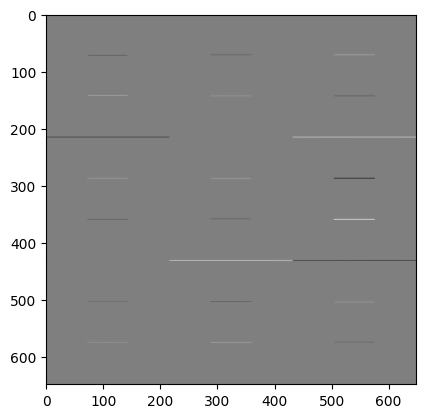

In [62]:
plt.imshow(r1, cmap="gray")
plt.show()

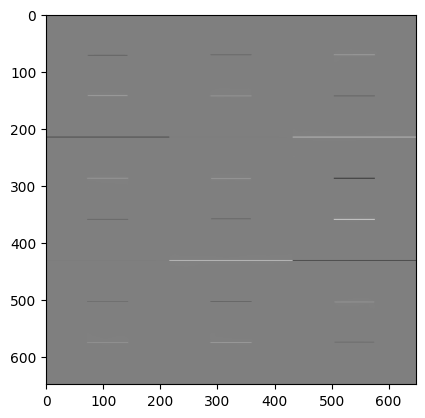

In [69]:
plt.imshow(r1p, cmap="gray")
plt.show()

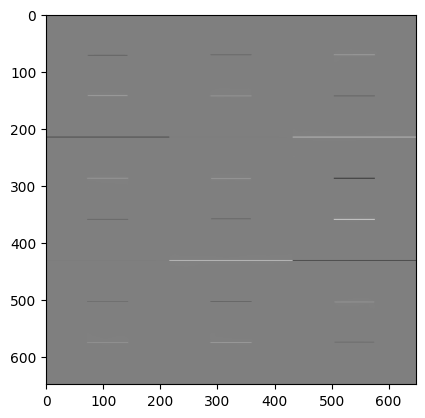

In [60]:
plt.imshow( r1, cmap="gray")
plt.show()

In [ ]:
plt.imshow( (R @ datap["x"].reshape(img_shape) - data["x"].reshape(img_shape), cmap="gray")
plt.show()

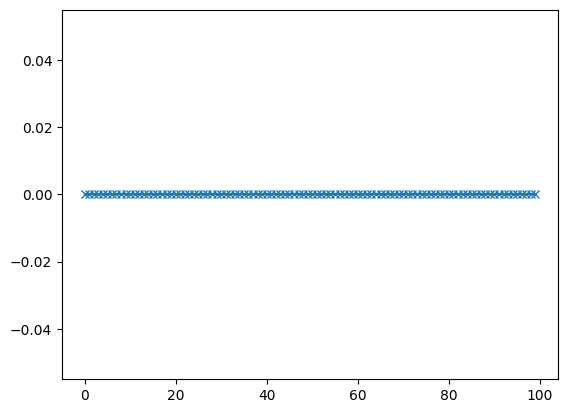

In [ ]:
plt.plot(data["n_Rpinv_matvec_cg_its_per_iteration"], marker="x")
plt.show()

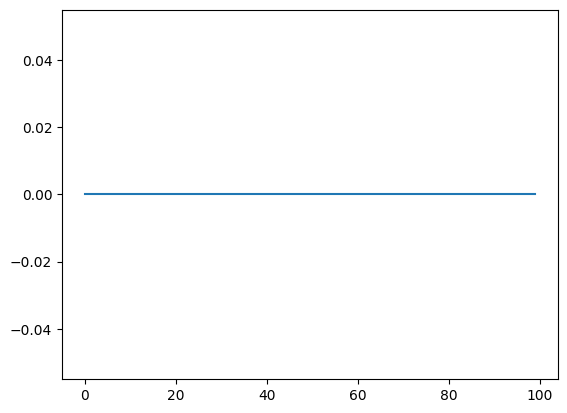

In [ ]:
plt.plot(data["n_Rpinv_matvec_cg_its_per_iteration"])
plt.show()

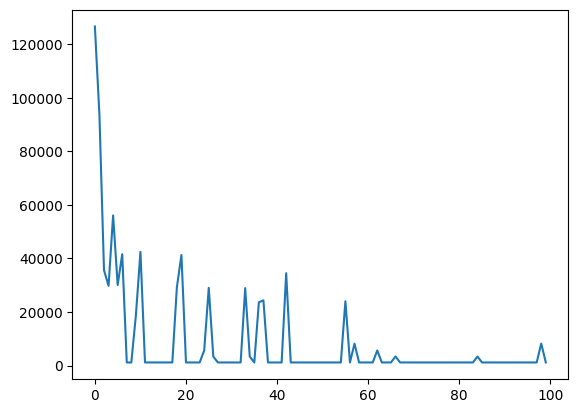

In [83]:
plt.plot(datap["n_Rpinv_matvec_cg_its_per_iteration"])
plt.show()

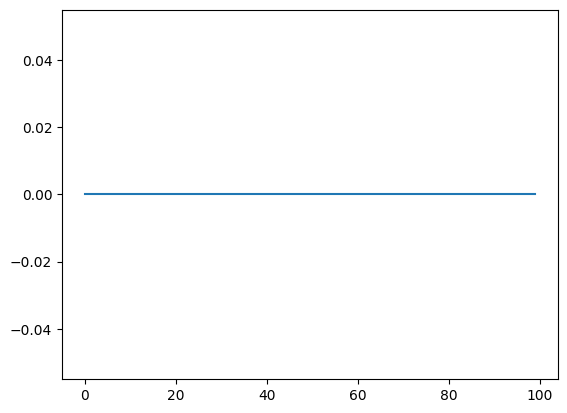

In [ ]:
plt.plot(data["n_Rpinv_matvec_cg_its_per_iteration"])
plt.show()

# Plots

# Old

In [ ]:
data.keys()

In [10]:
z = np.asarray(None)

In [11]:
np.all([a is None for a in z.flat])

True

In [8]:
cp.asnumpy(None)

array(None, dtype=object)

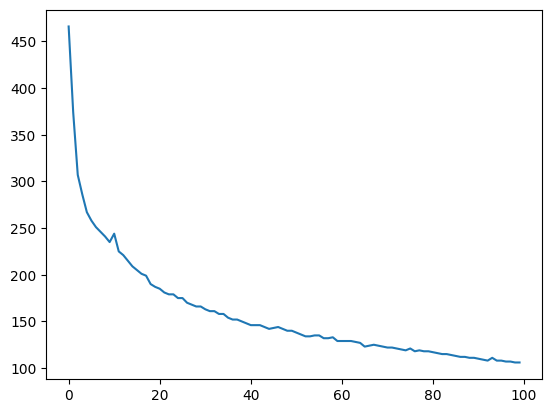

In [46]:
plt.plot(data["n_cg_its_per_iteration"])
plt.show()

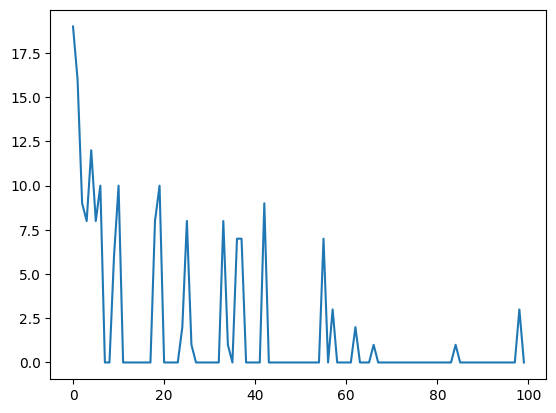

In [48]:
plt.plot(datap["n_cg_its_per_iteration"])
plt.show()

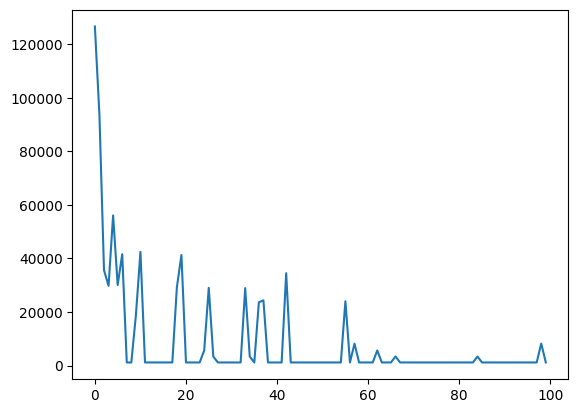

In [45]:
plt.plot(datap["n_Rpinv_matvec_cg_its_per_iteration"])
plt.show()

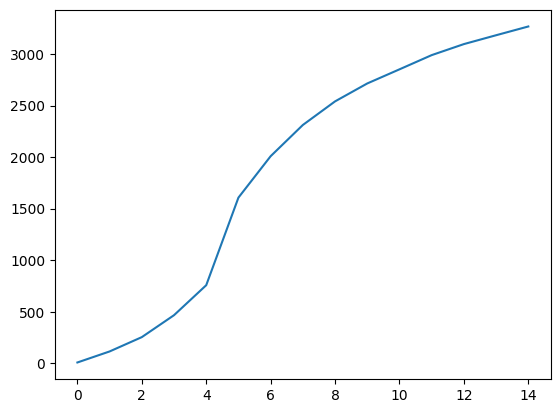

In [16]:
plt.plot(data["n_Rpinv_rmatvec_cg_its_per_iteration"])
plt.show()

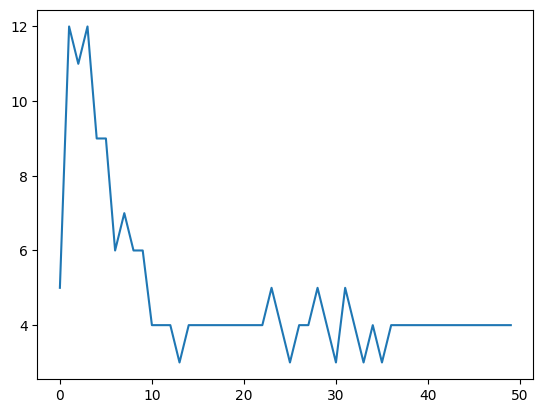

In [24]:
plt.plot(data["n_cg_its_per_iteration"])
plt.show()

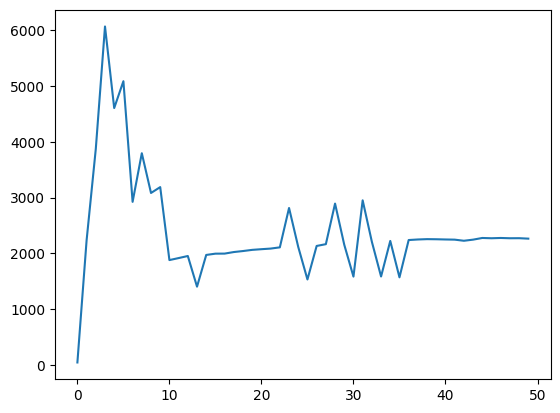

In [25]:
plt.plot(data["n_Rpinv_matvec_cg_its_per_iteration"])
plt.show()

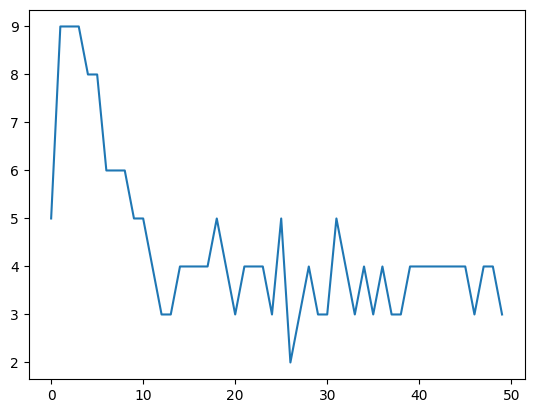

In [54]:
plt.plot(data["n_cg_its_per_iteration"])
plt.show()

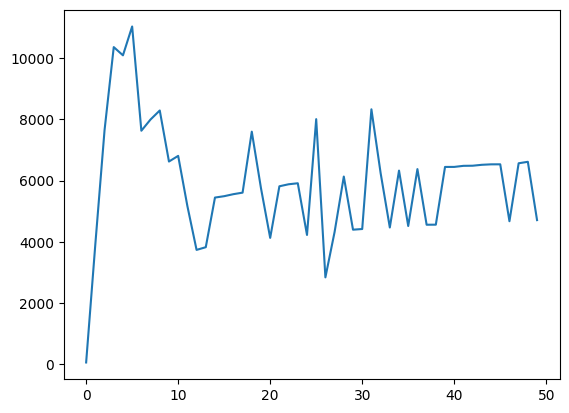

In [55]:
plt.plot(data["n_Rpinv_matvec_cg_its_per_iteration"])
plt.show()

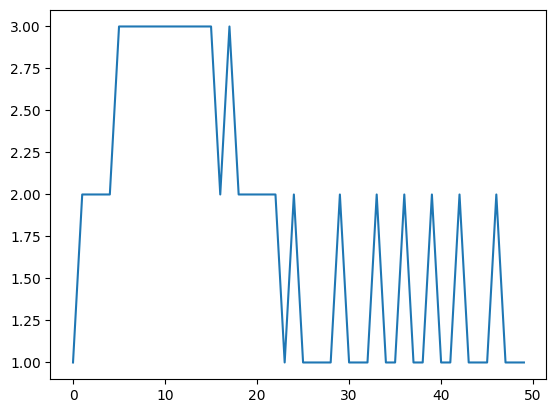

In [48]:
plt.plot(data["n_cg_its_per_iteration"])
plt.show()

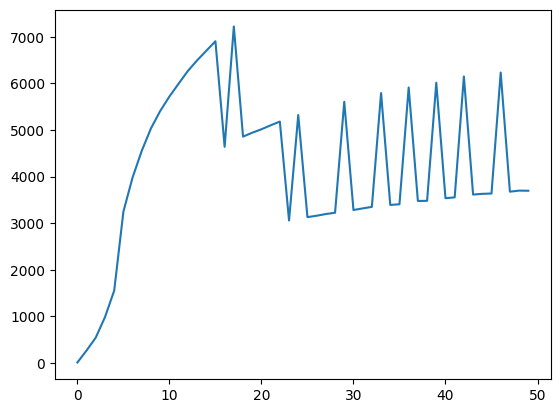

In [50]:
plt.plot(data["n_Rpinv_matvec_cg_its_per_iteration"])
plt.show()

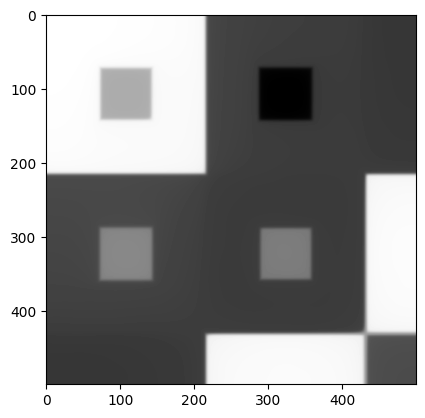

In [19]:
plt.imshow( data["x"].reshape(img_shape) , cmap="gray")
plt.show()

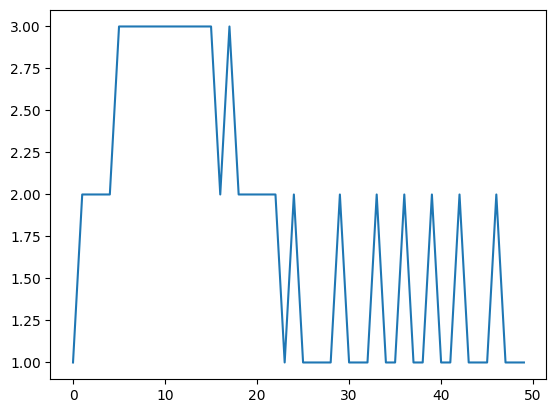

In [ ]:
plt.plot(data["n_cg_its_per_iteration"])
plt.show()

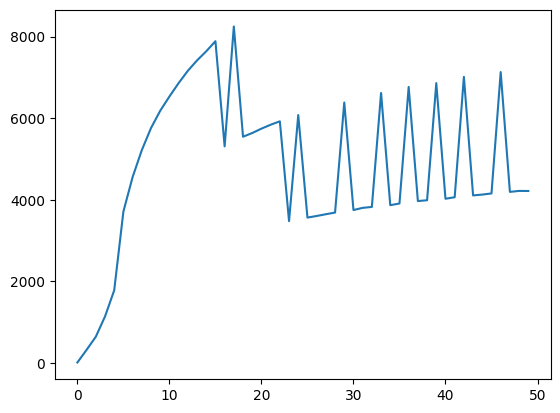

In [44]:
plt.plot(data["n_Rpinv_matvec_cg_its_per_iteration"])
plt.show()

In [ ]:
plt.plot(data["obj_vals"])
plt.show()

In [ ]:
plt.plot(data["n_cg_its_per_iteration"])
plt.show()

In [ ]:
plt.imshow( data["x"].reshape(img_shape) , cmap="gray")
plt.show()

# Noise variance learned

In [30]:
# Prior parameters
reg_lambda = 1e1
vartheta = 2/(reg_lambda**2)
hyperparams = {
    "prior": {
        "r": 1.0,
        "beta": 1.5 + 1e-3,
        "vartheta": vartheta,
    },
    "noise_var": {
        "r": -1.0,
        "beta": 1,
        "vartheta": 1e-4,
    }
}


# # Prior parameters
# hyperparams = {
#     "prior": {
#         "r": -1.0,
#         "beta": 1.0,
#         "vartheta": 1e-3,
#     },
#     # "noise_var": {
#     #     "r": -1.0,
#     #     "beta": 1,
#     #     "vartheta": 1e-4,
#     # }
# }



# Create solver
solver = sampi.IASSolver(F, R, noisy_signal, hyperparams, noise_var=None, pdata=pdata)

In [ ]:
data = solver.solve(max_iters=50, priorconditioning=False, 
                    early_stopping=True, warmstarting=True, 
                    eps=1e-3,
                   x_update_device="gpu")